# P2P Search Experiments — Plotting Summary + Per-Query Results
This notebook loads CSVs produced by `Stats` and plots:
- Avg latency vs experiment tag
- Throughput vs experiment tag
- Flood vs Random Walk on the same plots


In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt


In [36]:
tag = "m21"

In [37]:
# Load all summary CSVs
summary_files = glob.glob("run_outputs/summary/*.csv")
summary_files = [f for f in summary_files if tag in f]
if not summary_files:
    raise FileNotFoundError("No summary CSVs found in run_outputs/summary/. Run the simulator first.")

summ = pd.concat([pd.read_csv(f) for f in summary_files], ignore_index=True)
summ.head()


,protocol,tag,run,injected,served,avg_latency,throughput,forwards,hitsSent,hitsRecv
0,flood,m21_files20,1771036793247,10,10,6.800000,0.833333,44,13,13
1,rw,m21_files5,1771036748738,10,4,5.500000,0.500000,23,4,4
2,flood,m21_files10,1771036785186,10,8,6.875000,0.666667,66,9,9
3,rw,m21_files5,1771036748149,10,4,5.500000,0.500000,23,4,4
4,flood,m21_files5,1771036777489,10,6,5.833333,0.545455,63,6,6


In [38]:
# Ensure numeric columns are numeric
# (These names match the simplified writer: injected, served, avg_latency, throughput, forwards, hitsSent, hitsRecv)
for c in ["injected","served","avg_latency","throughput","forwards","hitsSent","hitsRecv"]:
    if c in summ.columns:
        summ[c] = pd.to_numeric(summ[c], errors="coerce")

print("Rows:", len(summ))
print("Protocols:", sorted(summ["protocol"].dropna().unique()))
print("Tags:", sorted(summ["tag"].dropna().unique()))


Rows: 30
Protocols: ['flood', 'rw']
Tags: ['m21_files10', 'm21_files20', 'm21_files5']


In [39]:
# Aggregate across multiple runs: mean + std for each (protocol, tag)
agg = (summ.groupby(["protocol","tag"], as_index=False)
           .agg(avg_latency_mean=("avg_latency","mean"),
                avg_latency_std=("avg_latency","std"),
                throughput_mean=("throughput","mean"),
                throughput_std=("throughput","std"),
                runs=("run","count")))
agg = agg.sort_values(["tag","protocol"])
agg


,protocol,tag,avg_latency_mean,avg_latency_std,throughput_mean,throughput_std,runs
0,flood,m21_files10,6.875000,0.0,0.666667,0.0,5
3,rw,m21_files10,7.000000,0.0,0.300000,0.0,5
1,flood,m21_files20,6.800000,0.0,0.833333,0.0,5
4,rw,m21_files20,7.444444,0.0,0.750000,0.0,5
2,flood,m21_files5,5.833333,0.0,0.545455,0.0,5
5,rw,m21_files5,5.500000,0.0,0.500000,0.0,5


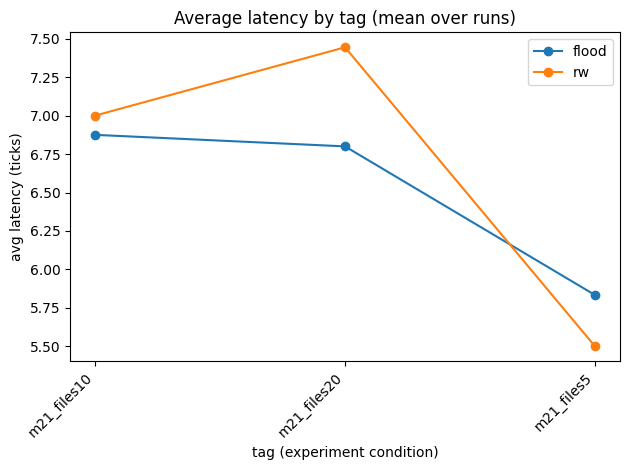

In [40]:
def plot_metric(metric_col, title, ylabel):
    tags = sorted(agg["tag"].unique())
    plt.figure()
    for protocol in sorted(agg["protocol"].unique()):
        g = agg[agg["protocol"] == protocol].set_index("tag").reindex(tags)
        plt.plot(tags, g[metric_col], marker="o", label=protocol)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("tag (experiment condition)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric("avg_latency_mean", "Average latency by tag (mean over runs)", "avg latency (ticks)")


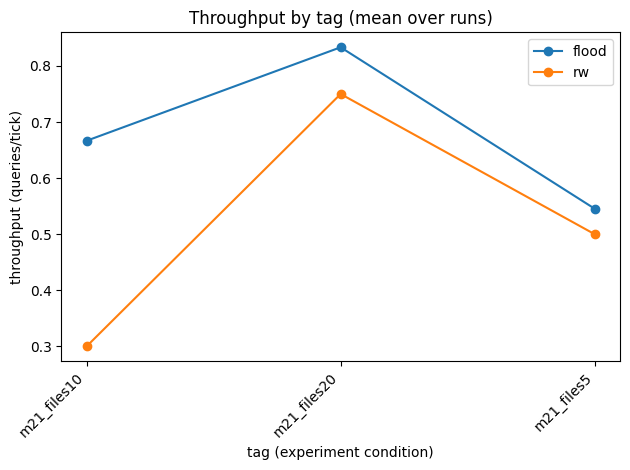

In [41]:
plot_metric("throughput_mean", "Throughput by tag (mean over runs)", "throughput (queries/tick)")
